<a href="https://colab.research.google.com/github/samohtwal/Bayesian-Personalized-Ranking/blob/main/Bayesian_Personalized_Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import copy
from itertools import islice
from google.colab import files
import os
import matplotlib.pyplot as plt

In [2]:
global data_user_column_name
data_user_column_name = 'user_id'

global data_item_column_name
data_item_column_name = 'item_id'

global data_group_by_user_id_dictionary_key
data_group_by_user_id_dictionary_key = 'data_group_by_user_id'

global data_group_by_item_id_dictionary_key
data_group_by_item_id_dictionary_key = 'data_group_by_item_id'

global user_latent_factor_matrix_dictionary_key
user_latent_factor_matrix_dictionary_key = 'user_latent_factor_matrix'

global item_latent_factor_matrix_dictionary_key
item_latent_factor_matrix_dictionary_key = 'item_latent_factor_matrix'

global working_file_path
working_file_path = '/content/working/'

global user_latent_factor_matrix_file_name
user_latent_factor_matrix_file_name = 'user_latent_factor_matrix.csv'

global item_latent_factor_matrix_file_name
item_latent_factor_matrix_file_name = 'item_latent_factor_matrix.csv'

global root_mean_square_error_file_name
root_mean_square_error_file_name = 'root_mean_square_error.csv'

In [3]:
class DataHelper:

    def load_raw_data_dictionary(self, data_url):

        column_names = [data_user_column_name, data_item_column_name]
        raw_data = pd.read_csv(data_url, names = column_names, header=0)

        data_group_by_user_id = raw_data.groupby(data_user_column_name)[data_item_column_name].apply(list).reset_index(name=data_item_column_name).sort_values(by=[data_user_column_name])
        data_group_by_item_id = raw_data.groupby(data_item_column_name)[data_user_column_name].apply(list).reset_index(name=data_user_column_name).sort_values(by=[data_item_column_name])

        data_dictionary = {
            data_group_by_user_id_dictionary_key: data_group_by_user_id, 
            data_group_by_item_id_dictionary_key: data_group_by_item_id
        }

        return data_dictionary

    def save_latent_factor_matrix_dictionary(self, latent_factor_matrix_dictionary):

        user_latent_factor_matrix = latent_factor_matrix_dictionary[user_latent_factor_matrix_dictionary_key]
        item_latent_factor_matrix = latent_factor_matrix_dictionary[item_latent_factor_matrix_dictionary_key]
        
        if os.path.exists(working_file_path) == False:
            os.mkdir(working_file_path)

        pd.DataFrame(user_latent_factor_matrix).to_csv(working_file_path + user_latent_factor_matrix_file_name, index=False, header=False)
        pd.DataFrame(item_latent_factor_matrix).to_csv(working_file_path + item_latent_factor_matrix_file_name, index=False, header=False)

        return None

    def load_latent_factor_matrix_dictionary(self):

        user_latent_factor_matrix = pd.read_csv(working_file_path + user_latent_factor_matrix_file_name, header=None).values
        item_latent_factor_matrix = pd.read_csv(working_file_path + item_latent_factor_matrix_file_name, header=None).values

        latent_factor_matrix_dictionary = {
            user_latent_factor_matrix_dictionary_key: user_latent_factor_matrix, 
            item_latent_factor_matrix_dictionary_key: item_latent_factor_matrix
        }

        return latent_factor_matrix_dictionary
    
    def save_root_mean_square_error(self, errors):
        if os.path.exists(working_file_path) == False:
            os.mkdir(working_file_path)
        pd.DataFrame(errors).to_csv(working_file_path + root_mean_square_error_file_name, index=False, header=False)

        return None

In [21]:
class BayseianPersonalizedRankingModel:

    def __init__(self, random_seed = 1234, n_latent_factor = 15, n_batch = 10, learning_rate = 0.01, regularization_constant = 0.01):
        self.random_seed = random_seed
        self.n_latent_factor = n_latent_factor
        self.n_batch = n_batch
        self.learning_rate = learning_rate
        self.regularization_constant = regularization_constant

    def fit(self, training_data_dictionary):

        training_data_group_by_user_id = training_data_dictionary[data_group_by_user_id_dictionary_key]
        training_data_group_by_item_id = training_data_dictionary[data_group_by_item_id_dictionary_key]

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        rstate = np.random.RandomState(self.random_seed)

        user_latent_factor_matrix = rstate.normal(size = (n_user, self.n_latent_factor))
        item_latent_factor_matrix = rstate.normal(size = (n_item, self.n_latent_factor))

        user_item_rating_matrix = self._create_user_item_rating_matrix(training_data_group_by_user_id, training_data_group_by_item_id)

        user_latent_factor_matrixes = []
        item_latent_factor_matrixes = []
        root_mean_square_errors = []

        is_converge = True
        index = 0
        while is_converge:

            # self.learning_rate = self.learning_rate * np.exp(-5*index)
            # self.learning_rate = self.learning_rate / (1 + 2 * index)
            
            sample_latent_factor_matrix_row_indexes = self._create_sample_latent_factor_matrix_row_indexes(training_data_group_by_user_id, training_data_group_by_item_id)
            sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes = sample_latent_factor_matrix_row_indexes
            user_latent_factor_matrix, item_latent_factor_matrix = self._update_sample_latent_factor_matrix_rows(user_latent_factor_matrix, item_latent_factor_matrix, sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes)
            
            sum_of_square_error = np.sum((user_item_rating_matrix - self._predict(user_latent_factor_matrix, item_latent_factor_matrix))**2)
            root_mean_square_error = np.sqrt((sum_of_square_error / n_user * n_item))

            user_latent_factor_matrixes.append(user_latent_factor_matrix)
            item_latent_factor_matrixes.append(item_latent_factor_matrix)
            root_mean_square_errors.append(root_mean_square_error)
            
            print('debug - iteration:', index+1, end='\n')
            print('debug - root_mean_square_error:', root_mean_square_error, end='\n')
            print('', end='\n')
            
            if (root_mean_square_errors[index] > root_mean_square_errors[index-1] 
                and root_mean_square_errors[index-1] > root_mean_square_errors[index-2]
                and root_mean_square_errors[index-2] > root_mean_square_errors[index-3]):
            # if index == 10:
                is_converge = False

            index = index + 1

        latent_factor_matrix_dictionary = {
            user_latent_factor_matrix_dictionary_key: user_latent_factor_matrixes[index-3], 
            item_latent_factor_matrix_dictionary_key: item_latent_factor_matrixes[index-3]
        }

        return latent_factor_matrix_dictionary, root_mean_square_errors[0:index-4]

    def _create_user_item_rating_matrix(self, training_data_group_by_user_id, training_data_group_by_item_id):

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        user_ids = training_data_group_by_user_id[data_user_column_name].tolist()
        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        user_item_rating_matrix = np.zeros((n_user, n_item), dtype = np.int64)
        for user_id_index, user_id in enumerate(user_ids):
            item_id_indexes = np.where(np.isin(training_data_group_by_user_id.iloc[user_id_index][data_item_column_name],item_ids))[0]
            for item_id_index in item_id_indexes:
                user_item_rating_matrix[user_id_index, item_id_index] = 1

        return user_item_rating_matrix

    def _create_sample_latent_factor_matrix_row_indexes(self, training_data_group_by_user_id, training_data_group_by_item_id):

        n_user = len(training_data_group_by_user_id[data_user_column_name])
        n_item = len(training_data_group_by_item_id[data_item_column_name])

        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        sample_user_id_indexes = np.random.choice(n_user, size = self.n_batch, replace = False)
        sample_positive_item_id_indexes = np.zeros(self.n_batch, dtype = np.int64)
        sample_negative_item_id_indexes = np.zeros(self.n_batch, dtype = np.int64)

        for index, sampled_user_id_index in enumerate(sample_user_id_indexes):
            possible_positive_item_ids = training_data_group_by_user_id.iloc[sampled_user_id_index][data_item_column_name]
            possible_negative_item_ids = list(set(item_ids).difference(possible_positive_item_ids))
            sample_positive_item_id = np.random.choice(possible_positive_item_ids)
            sample_negative_item_id = np.random.choice(possible_negative_item_ids)
            sample_positive_item_id_indexes[index] = item_ids.index(sample_positive_item_id)
            sample_negative_item_id_indexes[index] = item_ids.index(sample_negative_item_id)

        return sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes

    def _update_sample_latent_factor_matrix_rows(self, user_latent_factor_matrix, item_latent_factor_matrix, sample_user_id_indexes, sample_positive_item_id_indexes, sample_negative_item_id_indexes):

        sample_user_latent_factor_matrix_tuple = user_latent_factor_matrix[sample_user_id_indexes]
        sample_item_latent_factor_matrix_positive_item_tuple = item_latent_factor_matrix[sample_positive_item_id_indexes]
        sample_item_latent_factor_matrix_negative_item_tuple = item_latent_factor_matrix[sample_negative_item_id_indexes]

        r_uij = np.sum(sample_user_latent_factor_matrix_tuple * (sample_item_latent_factor_matrix_positive_item_tuple - sample_item_latent_factor_matrix_negative_item_tuple), axis = 1)
        sigmoid = np.exp(-r_uij) / (1.0 + np.exp(-r_uij))
        sigmoid_tiled = np.tile(sigmoid, (self.n_latent_factor, 1)).T

        gradient_user = sigmoid_tiled * (sample_item_latent_factor_matrix_negative_item_tuple - sample_item_latent_factor_matrix_positive_item_tuple) + self.regularization_constant * sample_user_latent_factor_matrix_tuple
        gradient_positive_item = sigmoid_tiled * -sample_user_latent_factor_matrix_tuple + self.regularization_constant * sample_item_latent_factor_matrix_positive_item_tuple
        gradient_negative_item = sigmoid_tiled * sample_user_latent_factor_matrix_tuple + self.regularization_constant * sample_item_latent_factor_matrix_negative_item_tuple

        user_latent_factor_matrix[sample_user_id_indexes] -= self.learning_rate * gradient_user
        item_latent_factor_matrix[sample_positive_item_id_indexes] -= self.learning_rate * gradient_positive_item
        item_latent_factor_matrix[sample_negative_item_id_indexes] -= self.learning_rate * gradient_negative_item

        return user_latent_factor_matrix, item_latent_factor_matrix

    def recommend(self, testing_data_dictionary, training_data_dictionary, latent_factor_matrix_dictionary, lower_bound_score, upper_bound_score, n_best_recommendation):

        testing_data_group_by_user_id = testing_data_dictionary[data_group_by_user_id_dictionary_key]

        n_user = len(testing_data_group_by_user_id[data_user_column_name])
        user_ids = user_ids = testing_data_group_by_user_id[data_user_column_name].tolist()

        recommendation_user_ids = []
        recommendation_item_ids = []
        for user_id in user_ids:
            best_recommendition_item_ids = self.recommend_user(training_data_dictionary, latent_factor_matrix_dictionary, user_id, lower_bound_score, upper_bound_score, n_best_recommendation)
            print('debug - len(best_recommendition_item_ids):', len(best_recommendition_item_ids), end='\n')
            print('', end='\n')
            for item_id in best_recommendition_item_ids:
                recommendation_user_ids.append(user_id)
                recommendation_item_ids.append(item_id)

        data = {'user_id': recommendation_user_ids, 'item_id': recommendation_item_ids}
        recommendation_data = pd.DataFrame.from_dict(data)

        recommendation_data_group_by_user_id = recommendation_data.groupby(data_user_column_name)[data_item_column_name].apply(list).reset_index(name=data_item_column_name).sort_values(by=[data_user_column_name])
        recommendation_data_group_by_item_id = recommendation_data.groupby(data_item_column_name)[data_user_column_name].apply(list).reset_index(name=data_user_column_name).sort_values(by=[data_item_column_name])

        recommendation_data_dictionary = {
            data_group_by_user_id_dictionary_key: recommendation_data_group_by_user_id, 
            data_group_by_item_id_dictionary_key: recommendation_data_group_by_item_id
        }

        return recommendation_data_dictionary

    def recommend_user(self, training_data_dictionary, latent_factor_matrix_dictionary, user_id, lower_bound_score, upper_bound_score, n_best_recommendation):

        training_data_group_by_user_id = training_data_dictionary[data_group_by_user_id_dictionary_key]
        training_data_group_by_item_id = training_data_dictionary[data_group_by_item_id_dictionary_key]

        user_latent_factor_matrix = latent_factor_matrix_dictionary[user_latent_factor_matrix_dictionary_key]
        item_latent_factor_matrix = latent_factor_matrix_dictionary[item_latent_factor_matrix_dictionary_key]

        user_ids = training_data_group_by_user_id[data_user_column_name].tolist()
        item_ids = training_data_group_by_item_id[data_item_column_name].tolist()

        n_item = len(training_data_group_by_item_id[data_item_column_name])

        user_index = user_ids.index(user_id)

        scores = self._predict_user(user_latent_factor_matrix, item_latent_factor_matrix, user_index)

        item_score_dictionary = {item_ids[i]: scores[i] for i in range(len(item_ids))}
        positive_item_ids = training_data_group_by_user_id.iloc[user_index][data_item_column_name]

        item_score_dictionary = {item_ids[i]: scores[i] for i in range(len(item_ids))}

        # item_score_dictionary = dict((key, value) for key, value in item_score_dictionary.items() if value >= lower_bound_score and value <= upper_bound_score)
        item_score_dictionary = dict(sorted(item_score_dictionary.items(), key=lambda item: item[1], reverse=True))
        best_recommendition_item_dictionary = dict(islice(item_score_dictionary.items(), n_best_recommendation))
        best_recommendition_item_ids = list(best_recommendition_item_dictionary.keys())

        return best_recommendition_item_ids

    def _predict(self, user_latent_factor_matrix, item_latent_factor_matrix):
        return user_latent_factor_matrix.dot(item_latent_factor_matrix.T)

    def _predict_user(self, user_latent_factor_matrix, item_latent_factor_matrix, user_index):
        return user_latent_factor_matrix[user_index].dot(item_latent_factor_matrix.T)


In [24]:
class ModelAnalyzerHelper:

    def plot_error_chart(self, root_mean_square_errors, bayseian_personalized_ranking_parameters):

        x  = range(len(root_mean_square_errors))
        y = root_mean_square_errors
        plt.plot(x, y, label='Learning Rate = ' + str(bayseian_personalized_ranking_parameters['learning_rate']))
        plt.plot()

        plt.xlabel("Iteration")
        plt.ylabel("Root Mean Square Error")
        plt.title("Root Mean Square Error / Iteration")
        plt.legend()
        plt.show()

        return None
    
    def evaluate(self, testing_data_dictionary, recommendation_data_dictionary):

        testing_data_group_by_user_id = testing_data_dictionary[data_group_by_user_id_dictionary_key]
        testing_user_ids = testing_data_group_by_user_id[data_user_column_name].tolist()

        testing_data_group_by_item_id = testing_data_dictionary[data_group_by_item_id_dictionary_key]
        testing_item_ids = testing_data_group_by_item_id[data_item_column_name].tolist()

        recommendation_data_group_by_user_id = recommendation_data_dictionary[data_group_by_user_id_dictionary_key]
        recommendation_user_ids = recommendation_data_group_by_user_id[data_user_column_name].tolist()

        n_true_positive = 0
        n_false_positive = 0
        n_true_negative = 0
        n_false_negative = 0

        for index, recommendation_user_id in enumerate(recommendation_user_ids):

            n_user_true_positive = 0
            n_user_false_positive = 0
            n_user_true_negative = 0
            n_user_false_negative = 0
            
            positive_testing_item_ids = testing_data_group_by_user_id.iloc[index][data_item_column_name]
            negative_testing_item_ids = list(set(testing_item_ids).difference(positive_testing_item_ids))
            positive_predition_item_ids = recommendation_data_group_by_user_id.iloc[index][data_item_column_name]
            negative_predition_item_ids = list(set(testing_item_ids).difference(positive_predition_item_ids))

            for positive_predition_item_id in positive_predition_item_ids:
                if positive_predition_item_id in positive_testing_item_ids: n_user_true_positive = n_user_true_positive + 1
                if positive_predition_item_id not in positive_testing_item_ids: n_user_false_positive = n_user_false_positive + 1

            for negative_predition_item_id in negative_predition_item_ids:
                if negative_predition_item_id in negative_testing_item_ids: n_user_true_negative = n_user_true_negative + 1
                if negative_predition_item_id not in negative_testing_item_ids: n_user_false_negative = n_user_false_negative + 1

            print('debug - recommendation_user_id:', recommendation_user_id, end='\n')
            print('debug - n_user_true_positive:', n_user_true_positive, end='\n')
            print('debug - n_user_false_positive:', n_user_false_positive, end='\n')
            print('debug - n_user_true_negative:', n_user_true_negative, end='\n')
            print('debug - n_user_false_negative:', n_user_false_negative, end='\n')
            print('', end='\n')

            n_true_positive = n_true_positive + n_user_true_positive
            n_false_positive = n_false_positive + n_user_false_positive
            n_true_negative = n_true_negative + n_user_true_negative
            n_false_negative = n_false_negative + n_user_false_negative

        print('debug - n_true_positive:', n_true_positive, end='\n')
        print('debug - n_false_positive:', n_false_positive, end='\n')
        print('debug - n_true_negative:', n_true_negative, end='\n')
        print('debug - n_false_negative:', n_false_negative, end='\n')
        print('', end='\n')

        true_positive_rate = n_true_positive / (n_true_positive + n_false_negative)
        false_positive_rate = n_false_positive / (n_false_positive + n_true_negative)

        precision = n_true_positive / (n_true_positive + n_false_positive)

        return true_positive_rate, false_positive_rate, precision

In [34]:
data_helper = DataHelper()
bayseian_personalized_ranking_parameters = {
    'random_seed' : 4321, 
    'n_latent_factor' : 15, 
    'n_batch' : 100, 
    'learning_rate' : 0.01, 
    'regularization_constant' : 0.01
}
bayseian_personalized_ranking_model = BayseianPersonalizedRankingModel(**bayseian_personalized_ranking_parameters)
model_analyzer_helper = ModelAnalyzerHelper()

In [35]:
training_data_url = 'https://raw.githubusercontent.com/samohtwal/Bayesian-Personalized-Ranking/main/data/train.csv'
training_data_dictionary = data_helper.load_raw_data_dictionary(training_data_url)

In [ ]:
latent_factor_matrix_dictionary, root_mean_square_errors = bayseian_personalized_ranking_model.fit(training_data_dictionary)
data_helper.save_latent_factor_matrix_dictionary(latent_factor_matrix_dictionary)
data_helper.save_root_mean_square_error(root_mean_square_errors)

Streaming output truncated to the last 5000 lines.
debug - root_mean_square_error: 5561.649203137869

debug - iteration: 16182
debug - root_mean_square_error: 5561.483182443683

debug - iteration: 16183
debug - root_mean_square_error: 5561.369307042214

debug - iteration: 16184
debug - root_mean_square_error: 5561.243804974731

debug - iteration: 16185
debug - root_mean_square_error: 5561.123890430709

debug - iteration: 16186
debug - root_mean_square_error: 5561.00663395225

debug - iteration: 16187
debug - root_mean_square_error: 5560.916567615801

debug - iteration: 16188
debug - root_mean_square_error: 5560.769290026869

debug - iteration: 16189
debug - root_mean_square_error: 5560.654343388593

debug - iteration: 16190
debug - root_mean_square_error: 5560.496540457623

debug - iteration: 16191
debug - root_mean_square_error: 5560.39378764643

debug - iteration: 16192
debug - root_mean_square_error: 5560.2483188981505

debug - iteration: 16193
debug - root_mean_square_error: 5560.0

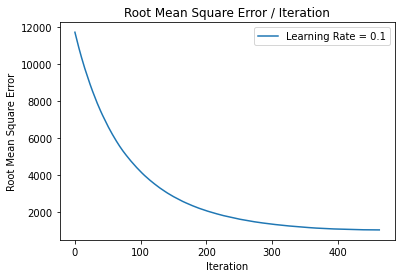

In [9]:
model_analyzer_helper.plot_error_chart(root_mean_square_errors, bayseian_personalized_ranking_parameters)

In [10]:
latent_factor_matrix_dictionary = data_helper.load_latent_factor_matrix_dictionary()

In [29]:
bayseian_personalized_ranking_parameters = {
    'random_seed' : 1234, 
    'n_latent_factor' : 15, 
    'n_batch' : 100, 
    'learning_rate' : 0.01, 
    'regularization_constant' : 0.01
}
bayseian_personalized_ranking_model = BayseianPersonalizedRankingModel(**bayseian_personalized_ranking_parameters)


vali_data_url = 'https://raw.githubusercontent.com/samohtwal/Bayesian-Personalized-Ranking/main/data/vali.csv'
vali_data_dictionary = data_helper.load_raw_data_dictionary(vali_data_url)

user_ids = vali_data_dictionary[data_group_by_user_id_dictionary_key][data_user_column_name].tolist()
user_id = np.random.choice(user_ids)
n_best_recommendation = 5
lower_bound_score = 0.5
upper_bound_score = 1.5
recommendation_item_ids = bayseian_personalized_ranking_model.recommend_user(training_data_dictionary, latent_factor_matrix_dictionary, user_id, lower_bound_score, upper_bound_score, n_best_recommendation)

print('debug - user_id:', user_id, end='\n')
print('debug - recommendation_item_ids:', recommendation_item_ids, end='\n')

recommendation_data_dictionary = bayseian_personalized_ranking_model.recommend(vali_data_dictionary, training_data_dictionary, latent_factor_matrix_dictionary, lower_bound_score, upper_bound_score, n_best_recommendation)

debug - user_id: 1145
debug - recommendation_item_ids: [682, 123, 136, 387, 265]
debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5

debug - len(best_recommendition_item_ids): 5


KeyboardInterrupt: ignored

In [28]:
model_analyzer_helper = ModelAnalyzerHelper()
true_positive_rate, false_positive_rate, precision = model_analyzer_helper.evaluate(vali_data_dictionary, recommendation_data_dictionary)

print('debug - true_positive_rate:', true_positive_rate, end='\n')
print('debug - false_positive_rate:', false_positive_rate, end='\n')
print('debug - precision:', precision, end='\n')
print('', end='\n')

Streaming output truncated to the last 5000 lines.
debug - n_user_false_negative: 18

debug - recommendation_user_id: 434
debug - n_user_true_positive: 1
debug - n_user_false_positive: 4
debug - n_user_true_negative: 2979
debug - n_user_false_negative: 13

debug - recommendation_user_id: 435
debug - n_user_true_positive: 0
debug - n_user_false_positive: 5
debug - n_user_true_negative: 2988
debug - n_user_false_negative: 4

debug - recommendation_user_id: 436
debug - n_user_true_positive: 0
debug - n_user_false_positive: 5
debug - n_user_true_negative: 2975
debug - n_user_false_negative: 17

debug - recommendation_user_id: 437
debug - n_user_true_positive: 0
debug - n_user_false_positive: 5
debug - n_user_true_negative: 2990
debug - n_user_false_negative: 3

debug - recommendation_user_id: 438
debug - n_user_true_positive: 2
debug - n_user_false_positive: 3
debug - n_user_true_negative: 2970
debug - n_user_false_negative: 22

debug - recommendation_user_id: 439
debug - n_user_true_posit

KeyboardInterrupt: ignored